# Making Predictions
### Michelle Wilkerson

The goal of this lesson is to explore different models and methods for making predictions using data related to gray wolves and Yellowstone National Park. Each model comes with its own pros and cons that need to be considered, and we hope that by the end of this, you will be able to think about possible benefits that come with different methodologies and be more critical of prediction techniques that you encounter.

##### Background

Yellowstone is a national park located in Wyoming, Montana, and Idaho, covering almost 3,500 square miles. It became the first National Park in the United States in 1872 under President Ulysses S. Grant. It is thought to not only be the first National Park in the United states, but also the first national park in the world.

<img src=http://d1njyp8tsu122i.cloudfront.net/wp-content/uploads/map-lodging-by-state_680x392.jpg width=600>

Yellowstone is famous primarily for two things:

First, for its geysers and hot springs. It contains about half of the world’s geysers, with over 450 active geysers. For comparison, the next second largest collection of active geysers has about 200. It is home to the world's tallest active geyser, Steamboat Geyser, and to the famous <a href="https://youtu.be/h9uRaEoEV-U?t=1m36s">Old Faithful Geyser</a>. 

The park is also famous for its wildlife. According to the National Park Service, Yellowstone is "home to the largest concentration of mammals in the lower 48 states," with 67 species of mammals, and over 325 different species of birds, fish, amphibians, and reptiles.

Despite being a National Park, the animals of Yellowstone were not originally offered special protections.
The <a href=https://www.nps.gov/yell/learn/management/yellowstoneprotectionact1872.htm>Yellowstone National Park Protection Act</a> said that the Secretary of the Interior would "provide against the wanton destruction of the fish and game found within [Yellowstone]," but made no specific provisions, and left wiggle room for interpretation. Of semi-recent attention has been the status of gray wolves in the park -- which are neither game nor fish, so under the Protection Act, were left on their own. 

<img src=http://d1njyp8tsu122i.cloudfront.net/wp-content/uploads/Yellowstone-Wildlife-Wolf-11.jpg width=400>

Historically, gray wolves roamed about <a href="https://www.nwf.org/Wildlife/Wildlife-Library/Mammals/Gray-Wolf.aspx">two-thirds</a> of the United States, with numbers estimated to be over a quarter-million, but by the 1960s, the only wild gray wolves in the lower 48 states were restricted to <a href="http://www.missionwolf.org/page/wild-wolf-history/">Michigan and Minnesota</a>.

With America's westward expansion came the tolling of the bells for wolves. Not only did they have to compete with settlers for space, but they were also hunted. Farmers and ranchers feared for their livestock, and successfully advocated for programs to reduce gray wolf populations. Beginning in the 19th century and continuing into the 20th, there were <a href="https://www.fws.gov/midwest/wolf/aboutwolves/biologue.htm">government programs that offered bounties for each wolf killed</a>. In 1880, the superintendent of Yellowstone had stated that <a href="http://www.pbs.org/wnet/nature/the-wolf-that-changed-america-wolf-wars-americas-campaign-to-eradicate-the-wolf/4312/">"the value of their [wolves and coyotes] hides and their easy slaughter with strychnine-poisoned carcasses have nearly led to their extermination.”</a> By the end of the 1920s, gray wolves had disappeared from most of the United States. 

<img src=http://www.hcn.org/issues/46.21/have-returning-wolves-really-saved-yellowstone/yellowstonewolves1-jpg/@@images/7fdf9c1c-9425-45dd-99a7-fe6f43ffa3a1.jpeg width=400>

In 1973, Greater Yellowstone was named as one of three recovery areas for the endangered gray wolf. From 1995 to 1997, 41 wild wolves from Montana and Canada were released in Yellowstone National Park, where their populations have been climbing since.
    
* Wolves in Yellowstone
    * Wolves in Yellowstone primarily feed on hooved animals, the most common being elk, and more deer and smaller animals during the summer.

##### Hypotheses

We will find that model selection is highly dependent on the data you are working with, so first, we are going to look at ours.

In [1]:
#import statements
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from scipy.optimize import minimize
import ipywidgets as widgets
from IPython.display import display
from matplotlib.ticker import FuncFormatter
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Our first data set contains the wolf and elk populations from 1994 to 2012, though there are some years missing in the late 90s. Below is a print-out of the table we will be working with.

In [3]:
# reading in our data from an existing file
data = pd.read_csv('wolf_and_elk_in_yellowstone.csv', thousands=',').drop('Notes', axis=1).dropna().reset_index(drop=True)
data

,Year,Elk Population,Wolf Population
0,1994,19045.0,0.0
1,1995,16791.0,0.0
2,1999,14538.0,118.0
3,2000,13400.0,177.0
4,2001,11969.0,227.0
5,2002,9215.0,271.0
6,2003,9215.0,301.0
7,2004,8335.0,324.0
8,2005,9545.0,325.0
9,2006,6588.0,390.0


To get a sense of the data, it is helpful to visualize it with graphs.

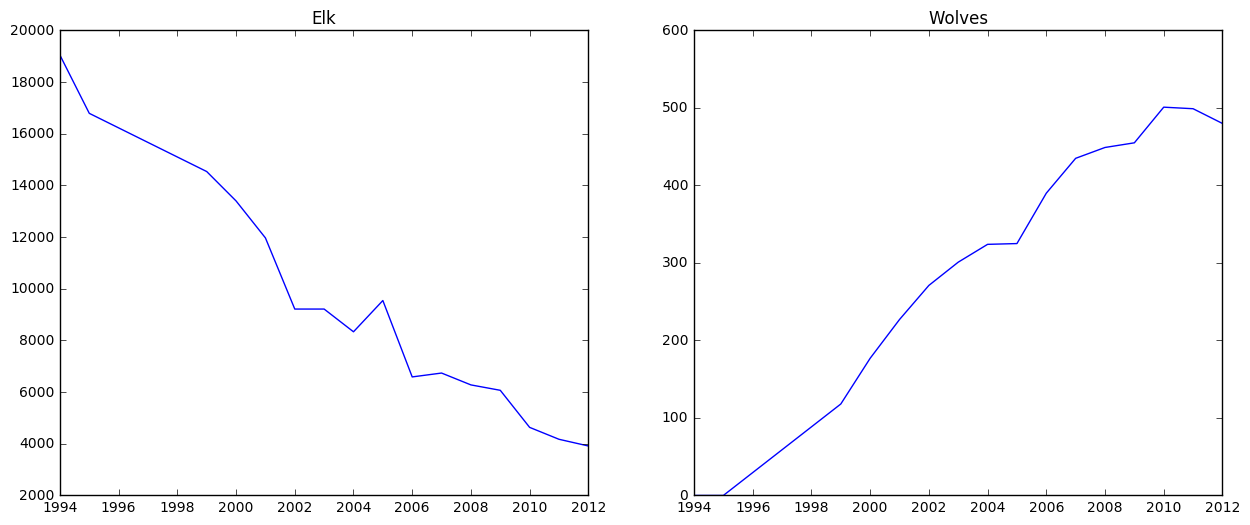

In [4]:
f, axs = plt.subplots(1,2,figsize=(15, 6))

axs[0].plot(data['Year'], data['Elk Population'])
axs[0].set_title('Elk')

axs[1].plot(data['Year'], data['Wolf Population'])
axs[1].set_title('Wolves')

Plotting the populations separately makes it difficult to see the the absolute changes in population relative to one another, so next, we will plot them on the same y-axis.

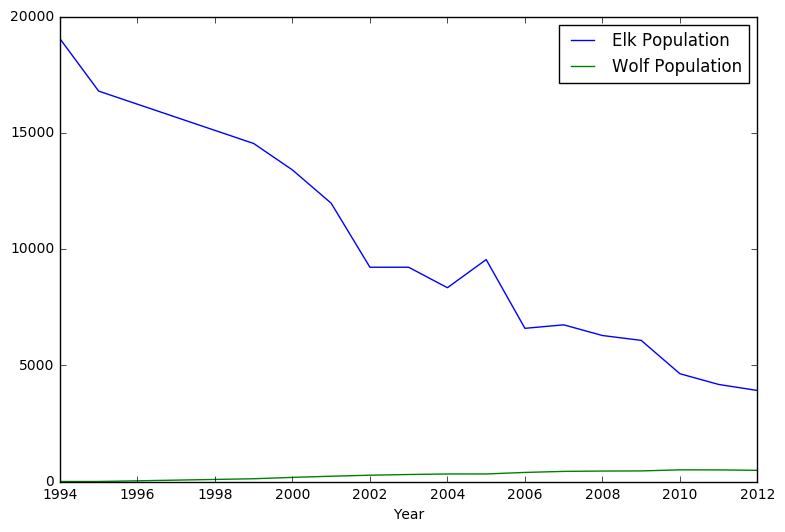

In [21]:
data.plot('Year', figsize=(9,6))

Another helpful view may be look at the percent change in population from year to year. Play with the slider to increase the length of the period (the number of years) that the percent change is measured over.

In [70]:
def percent_changing(periods=1):
    percent_changed = data.pct_change(periods)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    plt.plot(data['Year'], percent_changed['Elk Population'], c='b')
    plt.plot(data['Year'], percent_changed['Wolf Population'], c='r')
    plt.axhline(y=0, c="g")
    plt.legend()
    ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    plt.show()

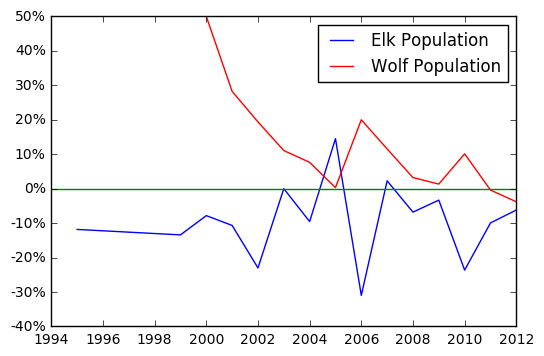

In [71]:
slider = widgets.IntSlider(min=1,max=6,step=1,value=1)
display(widgets.interactive(percent_changing, periods=slider))

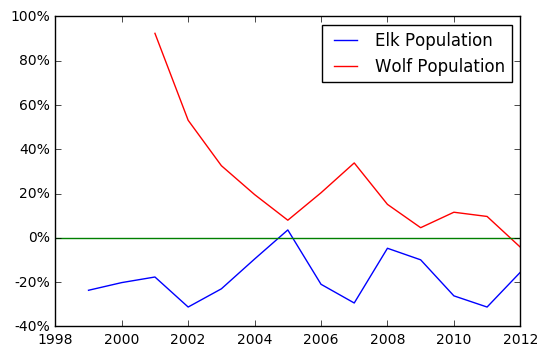

In [72]:
percent_changing(2)

<font color="blue">Question:</font> Based on the data and the graphs above, what do you think is going on with the wolf and elk populations? How do you think they will change going forward? Are they close to equilibrium?

* Students guess what they think the impact will be on park (touching on predator-prey interactions)

    * Other prey populations
    * Predator populations
    * Flora populations
    * Why?

##### Single Point Model

Now getting into the prediction portion, we are going to start basic. We are going to use 

* Simplest/most basic method


* Using one single point to predict the population in the following year


* What issues might arise with this method?

##### Linear Regression Model for Predicting Population

* All points
    * Creating regression line using data from every year
    * Use this regression line to predict population in future years

    
* Using N-most recent points
    * Creating regression line using data only from N-most recent years
    * Use this regression line to predict population in future years 
    
    
* Comparison
    * Compare the two models
    * How are they similar? How are they different? How are the findings/conclusions similar or different? What are the pros and cons of each?

##### K-Nearest Neighbor Model for Predicting Population

* What other factors might be related to wolf populations?

    
* Predator-Prey interactions
    * Prey is a very important factor, one of many factors
    * How do predators and their prey affect one another?
        * Predators kill and eat other organisms, their prey
        * Predator runs out of prey, dies out
    * Prey population typically peaks before predator population (usually ¼ of a cycle), natural oscillation
    
    
* Explain K-nearest neighbors (in layman terms)
    

* We can only choose some factors - which should we take into account? Why?


* The factors we chose/will use:
    * Elk population?
    * Bison population?
        * potential source for number of bison: http://ibmp.info/Library/OpsPlans/2016_StatusYellowstoneBisonPopulation_Sep2016.pdf
            * note on usage: population control measures are commonly used in yellowstone for bison

##### Comparison

* Compare all the models
    * Same questions as before
    * Which would you choose to use? Why?

##### Potential Issues with Data, Findings, etc?

##### Conclusion

* Takeaways


* Importance of findings/broader implications
    * Don’t know credible this video is but… https://www.facebook.com/newsnercom/videos/810945719072741/
    * Video in forwards

##### regression demo that shows what happens as you include more points in making your prediction

In [7]:
def regressiont(included_points=16):
    
    ignore = 16 - included_points  #indexes to ignore
    
    #prediction values
    yp = data['Wolf Population'][ignore:]
    tp = data['Year'][ignore:]
    
    #values
    y = data['Wolf Population']
    t = data['Year']
    
    #loss function
    def res(pars):
        a, b = pars
        yp_hat = a + b * tp
        res = yp - yp_hat
        return sum(res**2)
    
    #optimal paramters
    a, b = minimize(res, (-6.06621468e+04,   3.04230758e+01)).x
    
    #parameters for constant
    if included_points == 1:
        a, b = 480, 0
    
    y_hat = a + b * t  #precited values
    fitline = [y_hat.iloc[0], y_hat.iloc[-1]]  #fit line end points
    fittime = [t.iloc[0], t.iloc[-1]]  #fit line time values
    
    
    y_prime = a + b * 2013  #predicted point
    
    
    ax1 = plt.scatter(t, y, c='b')  #points
    ax2 = plt.plot(fittime, fitline, 'r--')  #fitline
    ax3 = plt.plot(tp, yp, 'rs')  #points used to predict
    ax4 = plt.scatter(t.iloc[-1] +1, y_prime, c='g', marker='^')  #predicted point
    
    #graph labels
    plt.xticks(t.append(pd.Series([2013]))[::2])
    plt.xlabel('Year')
    plt.ylabel('Wolf Popultion')
    
    #display graph and predicted value
    plt.show()
    print('Predicted 2013 wolf population:', round(y_prime))

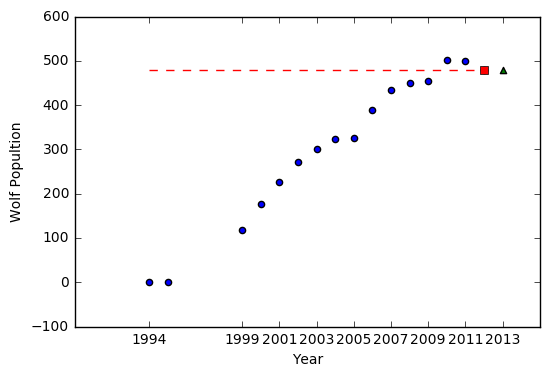

Predicted 2013 wolf population: 480


In [8]:
p_slider = widgets.IntSlider(min=1, max=16, step=1, value=1)
w=widgets.interactive(regressiont,included_points=p_slider)
display(w)

The visualation shows the changes in a linear model with no transformations on wolf population over time. The slider chooses how many observtions to include in the model. The blue dots are observations, red squared are observations included in model. red dashed line is fit line, and the green triangle is the predected population from the model for the next year.

I opted to use time instead of elk population because it made the visualization more intuitive with similar results. I also chose to include confidence bands because they also did not add to the narrative. These are options that could be included.

So far I have not found the actual 2013, the predicted year, wolf population to compare the different model memories to but this could be a useful addition

##### Making a graph that shows the points selected for kNN

In [9]:
def knn(neighbors=1):
    model = KNeighborsRegressor(neighbors)

    X = np.array([[-1, -1.5], [-2, -1.5], [-3, -2], [1, 1], [2, 1], [3, 3]])
    random_y_values = np.array([2,3,4,5,4,1])

    to_predict = [0,0]
    
    model.fit(X, random_y_values)
    dist, ind = model.kneighbors(to_predict)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))

    circle = plt.Circle(to_predict, max(dist[0]), color='g', alpha=.2)
    axes[0].add_artist(circle)

    axes[0].plot(to_predict[0], to_predict[1],'x', color='g', mew=3)

    axes[0].scatter(X[:,0], X[:,1], color='black')


    closest_points = X[ind[0]]
    
    axes[0].set_title('Distances')
    x_coords = closest_points.transpose()[0]
    y_coords = closest_points.transpose()[1]
    axes[0].scatter(x_coords, y_coords, color='r')
    
    for i in range(len(random_y_values)):
        position = X[i]
        axes[0].text(position[0]-.05, position[1]+.07, str(random_y_values[i]))
    
    
    num_points = len(ind[0])
    axes[1].set_xlim([0,7])
    axes[1].set_ylim([0,6])

    
    
    values = []
    for i in range(num_points):
        value = random_y_values[ind[0][i]]
        axes[1].vlines(x=i+1, ymin=0, ymax=value,
                       color='r', linewidths=15)
        values.append(value)
    axes[1].hlines(y=np.mean(values), xmin=0, xmax=12,
                  linestyles='dashed', linewidths=2, color='g')

    axes[1].set_title('Values of k closest')
    axes[1].set_xlabel('k')
    axes[1].set_ylabel('Value')
    plt.show()
    print('Predicted Value: ', np.mean(values))

Another model for predictions is K-Nearest Neighbors (kNN), which uses the "nearest neighbors" to a given point to make a prediction. In its name, the "K" is a placeholder for some number. For example, we could have a K equal to 3, so we would use the 3 nearest neighbors to make a prediction. We will be using kNN regression (as opposed to kNN classification). 

Depending on what kind of information you have, it can be help

A basic example of kNN regression is using proximity to other buildings to predict the height of a new one. Looking at our demo

Say that we want to predict the number of stories that a new apartment complex will have based on the apartment complexes that are around it.

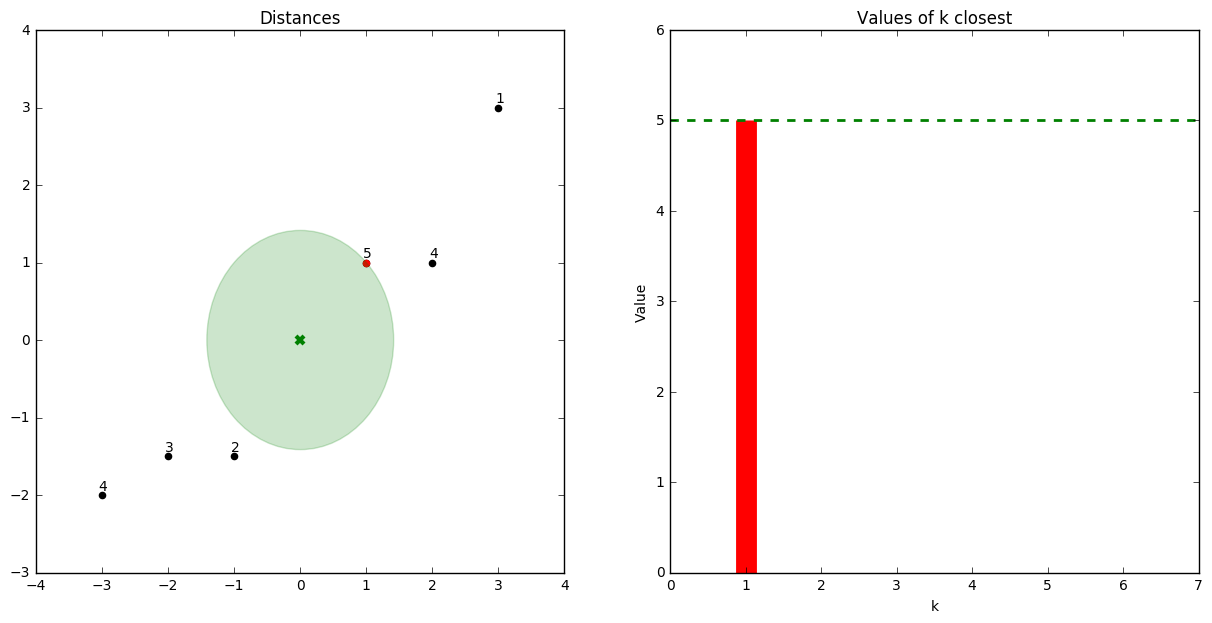

Predicted Value:  5.0


In [11]:
slider = widgets.IntSlider(min=1,max=6,step=1,value=1)
display(widgets.interactive(knn, neighbors=slider))

A commonly used model is the nearest-neighbors model. It is an expansion on the idea of the single-point model that we covered earlier.